In [1]:
from sklearn.datasets import load_iris

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
iris = load_iris()

features = ['sLength', 'sWidth', 'pLength', 'pWidth']
df = pd.DataFrame(iris.data, columns=features)

df = df.astype(int)  # to discrete var
df['y'] = iris.target_names[iris.target]

df.sample(5)

,sLength,sWidth,pLength,pWidth,y
113,5,2,5,2,virginica
99,5,2,4,1,versicolor
67,5,2,4,1,versicolor
56,6,3,4,1,versicolor
75,6,3,4,1,versicolor


## Naive Bayes

### Prior Probability

$$
Prob(Y = c_k)
$$

In [3]:
# prior probability

smooth_para = 1
K = len(df['y'].unique())

priorprob_s = df.groupby('y')['y'].apply(lambda x: (len(x) + smooth_para) / (len(df) + K*smooth_para))
priorprob_s

y
setosa        0.333333
versicolor    0.333333
virginica     0.333333
Name: y, dtype: float64

### Conditional Probability

$$
Prob(X = x | Y = c_k)
$$

conditional independent assumption:

$$
Prob(X = x| Y = c_k) = \prod_{j=1}^{M} Prob(X^{(j)} = x^{(j)} | Y = c_k)
$$

In [4]:
# conditional prob

M = len(features)
condprob_list = [None] * M

for j in range(M):
    feature = features[j]
    # todo: improvement of the nested apply:
    condprob_list[j] = df.groupby(feature).apply(
        lambda idf: idf.groupby('y')['y'].apply(
            lambda x: (x.count() + smooth_para) / (len(idf) + smooth_para * idf['y'].unique().__len__())))

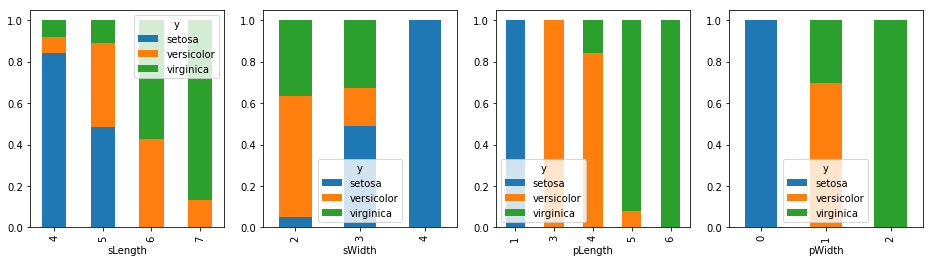

In [5]:
fig, axs = plt.subplots(1, M, figsize=(16, 4))

for j in range(M):
    data = condprob_list[j]
    data.unstack().plot(kind='bar', stacked=True, ax=axs[j])

### Posterior Probability

choose k from {1, 2, ..., K} to maximize 

$$
Prob(Y = c_k | X = x)
$$

according to P(A|B) formula:
$$
Prob(Y = c_k | X = x) = \frac{Prob(Y = c_k , X = x)}{Prob(X=x)}
$$

the denominator is constant for all k, what we need to maximize is only the numerator:

$$
\begin{align}
numerator & = Prob(X=x|Y=c_k) * Prob(Y=c_k) \\
          & = Prob(Y=c_k) * \Big(\prod Prob(X^{(j)} = x^{(j)} | Y=c_k)\Big)
\end{align}
$$

In [7]:
x_test = pd.Series([5, 2, 4, 1], index=features)
x_test

sLength    5
sWidth     2
pLength    4
pWidth     1
dtype: int64

In [ ]:
posterior_prob = priorprob_s * np.prod([condprob_list[j] for j in range(M)])

In [39]:
cond_prob_df = pd.DataFrame([condprob_list[j].loc[x_test[j]] for j in range(M)], index=range(M)).fillna(0)
cond_prob_df.index.name = 'j'
cond_prob_df

,setosa,versicolor,virginica
j,,,
0,0.484375,0.406250,0.109375
1,0.050000,0.583333,0.366667
2,0.000000,0.844444,0.155556
3,0.000000,0.698630,0.301370


In [45]:
posterior_prob = cond_prob_df.apply(np.prod, axis=0) * priorprob_s
posterior_prob

setosa        0.000000
versicolor    0.046602
virginica     0.000627
dtype: float64

In [47]:
posterior_prob.idxmax()

'versicolor'

## Python Notes

#### `stack()` and `unstack()`

multi-index Series  ==>  DataFrame: `s.unstack()`. `.stack()` vice versa

####  stacked barplot
stacked bar plot: `df.plot(kind='bar', stacked=True)`

#### pd.Series multiple: by key

`*` method for two pd.Series works on index/key:

In [20]:
x1 = pd.Series([1,2,3,4], index=['a', 'b', 'c', 'd'])
x2 = pd.Series([1,2,3], index=['a', 'c', 'b'])

x1 * x2

a    1.0
b    6.0
c    6.0
d    NaN
dtype: float64